<a href="https://colab.research.google.com/github/ny147/infant-classification/blob/main/sample_one_class_with%20smote(colab).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
%pip install tensorflow_io


     |████████████████████████████████| 23.4 MB 4.0 MB/s 


In [ ]:
!pip install -U imbalanced-learn

In [3]:
import os
import librosa, librosa.display
import matplotlib.pyplot as plt
from pathlib import Path
import tensorflow as tf
import tensorflow_io as tfio
import IPython.display as ipd
import numpy as np

In [5]:
from google.colab import drive
drive.mount('/content/drive/',force_remount=True)
path = '/content/drive/My Drive/Infant/'
#iris = pd.read_csv(path+"Iris.csv")

Mounted at /content/drive/


## Load Audio to Jupyter

In [ ]:


def load_audio(file_path):
    waveform, sample_rate = librosa.load(file_path)
    return waveform, sample_rate

def load_audio_files(path: str, label:str):

    dataset = []
    walker = sorted(str(p) for p in Path(path).glob(f'*.wav'))
    for i, file_path in enumerate(walker):
        path, filename = os.path.split(file_path)
        speaker, _ = os.path.splitext(filename)
        # speaker_id,version,gender,age,reason = speaker.split("-")
        #sp = speaker.split("-")
        #speaker_id = sp[0]
        #gender = sp[2]
        #age =sp[3]


        # Load audio
        waveform, sample_rate = load_audio(file_path)
        dataset.append([waveform, sample_rate])
        #dataset.append([waveform, sample_rate, label, speaker_id, gender,age])

    return dataset



## Prepare Data

In [ ]:
trainset_speechcommands_hungry = load_audio_files('./data/hungry', 'hungry')
trainset_speechcommands_burping = load_audio_files('./data/burping', 'burping')
trainset_speechcommands_tired = load_audio_files('./data/tired', 'tired')
trainset_speechcommands_belly_pain = load_audio_files('./data/belly_pain', 'belly_pain')
trainset_speechcommands_discomfort = load_audio_files('./data/discomfort', 'discomfort')


In [ ]:
print(f'Length of hungry dataset: {len(trainset_speechcommands_hungry)}')
print(f'Length of burping dataset: {len(trainset_speechcommands_burping)}')
print(f'Length of tired dataset: {len(trainset_speechcommands_tired)}')
print(f'Length of belly_pain dataset: {len(trainset_speechcommands_belly_pain)}')
print(f'Length of discomfort dataset: {len(trainset_speechcommands_discomfort)}')

Length of hungry dataset: 382
Length of burping dataset: 8
Length of tired dataset: 24
Length of belly_pain dataset: 16
Length of discomfort dataset: 27


In [ ]:
hungry_waveform = trainset_speechcommands_hungry[0][0]
hungry_sample_rate = trainset_speechcommands_hungry[0][1]
print(f'Yes Waveform: {hungry_waveform}')
print(f'Yes Sample Rate: {hungry_sample_rate}')
#print(f'Yes Label: {trainset_speechcommands_hungry[0][2]}')
#print(f'Yes ID: {trainset_speechcommands_hungry[0][3]}')

Yes Waveform: [ 1.2662281e-06  1.4249257e-06 -1.5742867e-08 ... -2.9080665e-02
 -2.0946175e-02 -9.9853482e-03]
Yes Sample Rate: 22050


## Waveform plot

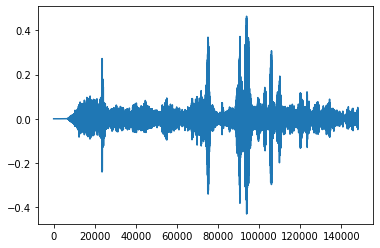

In [ ]:
timescale = np.arange(hungry_waveform .shape[0])
plt.figsize=(12, 8)
plt.plot(timescale, hungry_waveform)
plt.show()

In [ ]:
import IPython.display as ipd
ipd.Audio(hungry_waveform, rate=hungry_sample_rate)

In [ ]:
print(tf.shape(hungry_waveform))

tf.Tensor([148176], shape=(1,), dtype=int32)


## Spectrogram

In [ ]:
def get_spectrogram(waveform):

    frame_length = 255
    frame_step = 128
    # Padding for files with less than 16000 samples
    # zero_padding = tf.zeros([56000] - tf.shape(waveform), dtype=tf.float32)
    zero_padding = tf.zeros([60000] - tf.shape(waveform), dtype=tf.float32)
    
    # Concatenate audio with padding so that all audio clips will be of the same length
    waveform = tf.cast(waveform, tf.float32)
    equal_length_waveform = tf.concat([waveform, zero_padding], 0)

    # Option 1: Use tfio to get the spectrogram
    spect = tfio.audio.spectrogram(input=equal_length_waveform, nfft=frame_length, window=frame_length, stride=frame_step)

    # Option 2: Use tf.signal processing to get the Short-time Fourier transform (stft)
    spectrogram = tf.signal.stft(equal_length_waveform, frame_length=frame_length, frame_step=frame_step)
    spectrogram = tf.abs(spectrogram)

    return spectrogram, spect

In [ ]:
def get_spectrogram2(waveform,sample):
    fast_fourier_transf = np.fft.fft(waveform)
    
    magnitude = np.abs(fast_fourier_transf)
    
    frequency = np.linspace(0, sample, len(magnitude))
    
    left_mag = magnitude[:int(len(magnitude)/2)]
    left_freq = frequency[:int(len(frequency)/2)]
    
    n_fft = 2205
    
    hop_length = 220
    
    audio_stft = librosa.core.stft(waveform, hop_length=hop_length, n_fft=n_fft)
    
    # gathering the absolute values for all values in our audio_stft 
    spectrogram = np.abs(audio_stft)
    
    # Converting the amplitude to decibels
    log_spectro = librosa.amplitude_to_db(spectrogram)
    
    return log_spectro

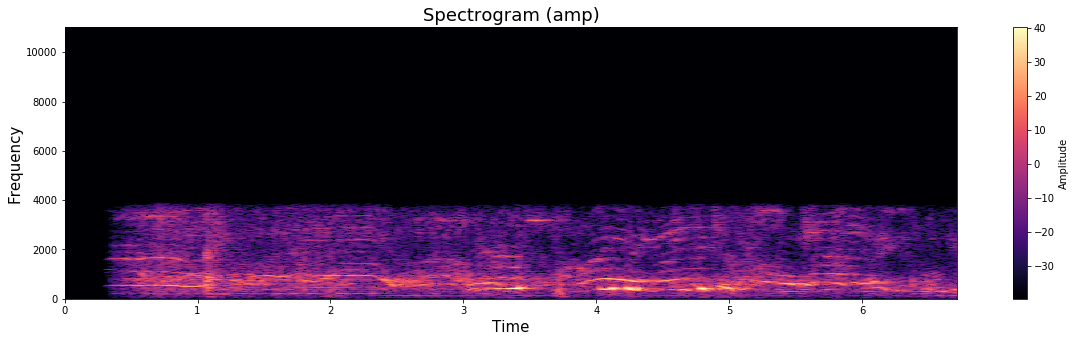

In [ ]:
#spectrogram, spect = get_spectrogram(hungry_waveform)
log_sp = get_spectrogram2(hungry_waveform,hungry_sample_rate)
plt.figure(figsize=(20, 5))
librosa.display.specshow(log_sp,sr=hungry_sample_rate, x_axis='time',y_axis='hz',hop_length=220,cmap='magma')
plt.colorbar(label='Amplitude')
plt.title('Spectrogram (amp)', fontdict=dict(size=18))
plt.xlabel('Time', fontdict=dict(size=15))
plt.ylabel('Frequency', fontdict=dict(size=15))
plt.show()

##  Create Spectrogram image for classification

In [ ]:
def create_images(dataset, label_dir,path,num):
    # make directory
    test_directory = f'./test_oneclass/{path}/{label_dir}/'
    train_directory = f'./train_oneclass/{path}/{label_dir}/'

    os.makedirs(test_directory, mode=0o777, exist_ok=True)
    os.makedirs(train_directory, mode=0o777, exist_ok=True)
    for i, data in enumerate(dataset):
        sample_rate = data[1]
        waveform = data[0]
        spectrogram = get_spectrogram2(waveform,sample_rate)
        
        # Split test and train images by 30%
        if i % 3 == 0:
            plt.imsave(f'./data/test_oneclass/{path}/{label_dir}/spec_img{i}{num}.jpg', spectrogram, cmap='magma')
        else:
            plt.imsave(f'./data/train_oneclass/{path}/{label_dir}/spec_img{i}{num}.jpg', spectrogram, cmap='magma')



In [ ]:
create_images(trainset_speechcommands_hungry, 'hungry','hungry_one',0)
create_images(trainset_speechcommands_tired, 'non_hungry','hungry_one',1)
create_images(trainset_speechcommands_burping, 'non_hungry','hungry_one',2)
create_images(trainset_speechcommands_discomfort, 'non_hungry','hungry_one',3)
create_images(trainset_speechcommands_belly_pain, 'non_hungry','hungry_one',4)

NameError: ignored

In [ ]:
create_images(trainset_speechcommands_tired, 'non_discomfort','discomfort_one',1)
create_images(trainset_speechcommands_burping, 'non_discomfort','discomfort_one',2)
create_images(trainset_speechcommands_discomfort, 'discomfort','discomfort_one',3)
create_images(trainset_speechcommands_belly_pain, 'non_discomfort','discomfort_one',4)

In [ ]:
create_images(trainset_speechcommands_tired, 'tired','tired_one',1)
create_images(trainset_speechcommands_burping, 'non_tired','tired_one',2)
create_images(trainset_speechcommands_belly_pain, 'non_tired','tired_one',4)

In [ ]:
create_images(trainset_speechcommands_burping, 'burping','burping_one',2)
create_images(trainset_speechcommands_belly_pain, 'non_burping','burping_one',4)

In [ ]:
train_directory = './data/train_oneclass/hungry_one'
test_directory = './data/test_oneclass/hungry_one'

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_directory, labels='inferred', label_mode='int', image_size=(256, 256), seed = 321
    ,validation_split=0.2, subset='training')
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_directory, labels='inferred', label_mode='int', image_size=(256, 256)
    ,validation_split=None, subset=None)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_directory, labels='inferred', label_mode='int', image_size=(256, 256), seed=321,
    validation_split=0.2, subset='validation')

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test_directory, labels='inferred', label_mode='int', image_size=(256, 256),
    validation_split=None, subset=None)

class_names = train_ds.class_names
print(class_names)

In [ ]:
type(test_ds)

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

## Create Model

In [6]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [7]:
from imblearn.over_sampling import SMOTE

In [26]:
train_directory = path +'/train_oneclass/hungry_one'
test_directory = path + '/test_oneclass/hungry_one'

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_directory, labels='inferred', label_mode='int', image_size=(256, 256), seed = 321
    ,validation_split=0.2, subset='training')
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_directory, labels='inferred', label_mode='int', image_size=(256, 256)
    ,validation_split=None, subset=None)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_directory, labels='inferred', label_mode='int', image_size=(256, 256), seed=321,
    validation_split=0.2, subset='validation')

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test_directory, labels='inferred', label_mode='int', image_size=(256, 256),
    validation_split=None, subset=None)
class_names_train = train_ds.class_names
class_names_test = train_ds.class_names
print(class_names_train)
print(class_names_test)

Found 303 files belonging to 2 classes.
Using 243 files for training.
Found 303 files belonging to 2 classes.
Found 303 files belonging to 2 classes.
Using 60 files for validation.
Found 154 files belonging to 2 classes.
['hungry', 'non_hungry']
['hungry', 'non_hungry']


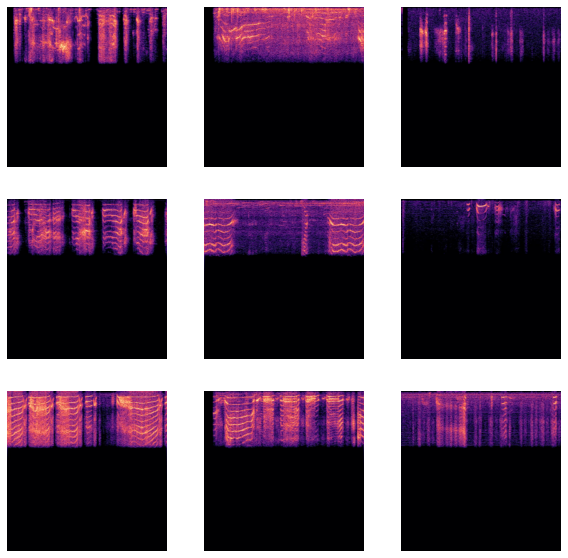

In [90]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        #plt.title(class_names[labels[i]])
        plt.axis("off")

In [92]:
x_train=[]
y_train=[]
for images, labels in train_ds.unbatch().take(-1):
    x_train.append(images.numpy())
    y_train.append(labels.numpy())

In [93]:
x_test=[]
y_test=[]
for images, labels in test_ds.unbatch().take(-1):
    x_test.append(images.numpy())
    y_test.append(labels.numpy())

In [68]:
sm = SMOTE(random_state=42)

In [69]:
x_train = np.array(x_train)

In [70]:
y_train = np.array(y_train)

In [75]:
x_train_reshape = x_train.reshape(303,256*256*3)

In [76]:
x_train_sm,y_train_sm = sm.fit_resample(x_train_reshape,y_train)

In [80]:
x_train_sm.shape

(508, 196608)

In [82]:
x_train_final = x_train_sm.reshape(508,256,256,3)

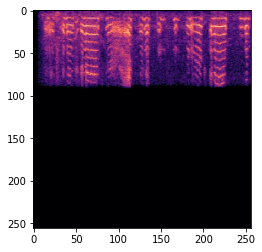

In [95]:
plt.imshow(x_train_final[0].astype("uint8"))

In [96]:
num_classes = 2
img_height = 256
img_width = 256

In [97]:
def create_weight(n_sample,n_class,n_class_sample):
    weight = n_sample/(n_class*n_class_sample)
    return weight

In [116]:
np.count_nonzero(y_train_sm == 1 )

254

In [130]:
model = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
    tf.keras.layers.Conv2D(16, 3, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D((3,3)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D((3,3)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D((3,3)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [131]:
learning_rate =  0.002
loss_fn = tf.keras.losses.BinaryCrossentropy(from_logits=True)
#loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
# optimizer = tf.keras.optimizers.SGD(learning_rate)
#optimizer = tf.keras.optimizers.Adadelta(learning_rate)
#optimizer = tf.keras.optimizers.Adamax(learning_rate)
optimizer = tf.keras.optimizers.Adam(learning_rate)
metrics = ['accuracy']
model.compile (optimizer = optimizer,loss =  loss_fn,metrics = metrics)

In [133]:
# Set the epocks
epochs = 10
history = model.fit(x_train_final,y_train_sm, epochs=epochs)

Epoch 1/10


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


16/16 [==============================] - 26s 1s/step - loss: 0.7074 - accuracy: 0.4902
Epoch 2/10
16/16 [==============================] - 20s 1s/step - loss: 0.6926 - accuracy: 0.4921
Epoch 3/10
16/16 [==============================] - 20s 1s/step - loss: 0.6868 - accuracy: 0.6299
Epoch 4/10
16/16 [==============================] - 20s 1s/step - loss: 0.6567 - accuracy: 0.6496
Epoch 5/10
16/16 [==============================] - 20s 1s/step - loss: 0.6280 - accuracy: 0.6398
Epoch 6/10
16/16 [==============================] - 20s 1s/step - loss: 0.6130 - accuracy: 0.6969
Epoch 7/10
16/16 [==============================] - 20s 1s/step - loss: 0.6002 - accuracy: 0.7106
Epoch 8/10
16/16 [==============================] - 20s 1s/step - loss: 0.5764 - accuracy: 0.7047
Epoch 9/10
16/16 [==============================] - 20s 1s/step - loss: 0.5601 - accuracy: 0.7264
Epoch 10/10
16/16 [==============================] - 20s 1s/step - loss: 0.5867 - accuracy: 0.7067


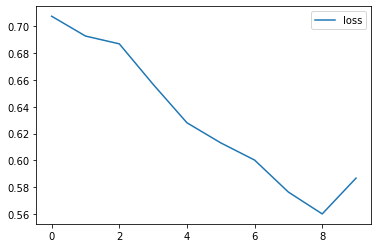

In [134]:
plt.plot(history.history['loss'],label = 'loss')
#plt.plot(history.history['val_loss'],label = 'val_loss')
plt.legend()
plt.show()

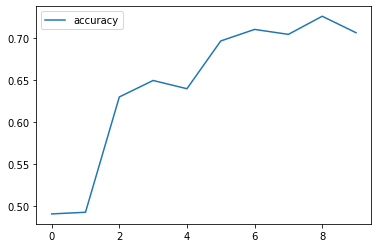

In [137]:
plt.plot(history.history['accuracy'],label = 'accuracy')
#plt.plot(history.history['val_accuracy'],label = 'val_accuracy')
plt.legend()
plt.show()

In [138]:
def binary_transform(pred):
    if pred > 0.5:
        predicted = 1
    else:
        predicted = 0
    return predicted 

In [140]:
correct = 0
batch_size = 0
sum_size = 0
count = 0
y_pred = []
y_true = []
for batch_num, (X, Y) in enumerate(test_ds):
    batch_size = len(Y)
    sum_size = sum_size + batch_size
    pred = model.predict(X)
    #print(pred)
    for i in range(batch_size):
        #predicted = np.argmax(pred[i], axis=-1)
        #print(predicted)
        predicted = binary_transform(pred[i])
        actual = Y[i]
        y_pred.append(predicted)
        y_true.append(actual)
        #print(f'predicted {predicted}, actual {actual}')
        if predicted == actual:
            correct += 1
    #break

print(f'Number correct: {correct} out of {sum_size}')
print(f'Accuracy {correct / sum_size}')

Number correct: 102 out of 154
Accuracy 0.6623376623376623


<function matplotlib.pyplot.show>

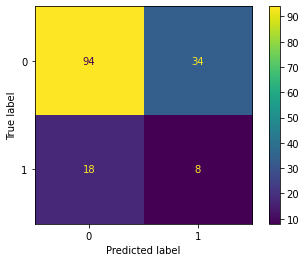

In [141]:
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=[0,1])
disp.plot()
plt.show